<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/playground_series_s3e22/undraw_Working_late_re_0c3y.png" width=400px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S3E22 - Horse Health Outcome</p>


In [98]:
# %load ../general_settings.py
import glob
import os
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, singledispatch
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.core.display import HTML, display_html
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

from shap import maskers
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Data Frame color theme.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"

CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #FFFCFA",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #4A4B52; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#BAB8B8", as_cmap=True)

MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 11,
    "axes.labelpad": 15,
    # "axes.labelweight": "bold",
    "axes.titlesize": 14,
    # "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "axes.grid": False,
    "axes.facecolor": BACKGROUND_COLOR,
    "xtick.labelsize": 11,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 11,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 11,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)

# Utility functions.
def download_from_kaggle(expr: list[str], directory: Path | None = None, /) -> None:
    if directory is None:
        directory = Path("data")
    if not isinstance(directory, Path):
        raise TypeError("The `directory` argument must be `Path` instance!")
    match expr:
        case ["kaggle", _, "download", *args] if args:
            directory.parent.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (directory / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, directory)
                shutil.move(filename, directory)
        case _:
            raise SyntaxError("Invalid expression!")


def get_interpolated_colors(color1: str, color2: str, /, num_colors: int = 2) -> list[str]:
    """Return `num_colors` interpolated beetwen `color1` and `color2`.
    Arguments need to be HEX."""

    def interpolate_color(color1, color2, t) -> str:
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    num_colors = num_colors + 2
    return [interpolate_color(color1, color2, i / (num_colors - 1)) for i in range(num_colors)]


# Html highlight. Must be included at the end of all imports!
HTML(
    """
<style>
code {
    background: rgba(42, 53, 125, 0.10) !important;
    border-radius: 4px !important;
}
a {
    color: rgba(123, 171, 237, 1.0) !important;
}
ol.numbered-list {
  counter-reset: item;
}
ol.numbered-list li {
  display: block;
}
ol.numbered-list li:before {
  content: counters(item, '.') '. ';
  counter-increment: item;
}
</style>
"""
)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The dataset for this competition is a synthetic dataset based off of the <a href="https://www.kaggle.com/datasets/yasserh/horse-survival-dataset"><b>Horse Survival Dataset</b></a>. As we can read in the original dataset description, the main task of the dataset is to understand the data and assess whether a horse can survive or not based on medical conditions. The original dataset is rich in missing values and according to the author, this issue is a real problem there. Moreover, all indicators were converted into words to understand what they represent easily.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    This is a multiclass classification problem, where the main task is to predict the <code>Outcome</code> feature ($3$ classes) about horse health status. The competition evaluation metric is <a href="https://en.wikipedia.org/wiki/F-score"><b>Micro-Averaged F1-Score</b></a> (a harmonic mean of precision and recall):
    \[F_1 =\frac{2}{\textrm{Precision}^{-1} + \textrm{Recall}^{-1}},\]
    where <i>Micro-Averaged</i> means calculate metrics globally by counting the total true positives, false negatives and false positives.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC. If you want quickly find out something about the dataset, just read the first section, i.e. <b>Quick Overview</b>.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #3A5A81;
    border-radius: 2px;
    border: 1px solid #3A5A81;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview"><span style="color: #F2F2F0">Quick Overview</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#data_reading_and_features_description"><span style="color: #F2F2F0">Data Reading &amp; Features Description</span></a></li>
        <li><a href="#basic_numerical_properties_summaries"><span style="color: #F2F2F0">Basic Numerical Properties &amp; Summaries</span></a></li>
        <li><a href="#category_sharing"><span style="color: #F2F2F0">Category Sharing</span></a></li>
        <li><a href="#lgbm_baseline"><span style="color: #F2F2F0">LGBM Baseline</span></a></li>
    </ol>
    <li><a href="#missing_values_imputation"><span style="color: #F2F2F0">Missing Values Imputation</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#correlation_between_categorical_variables"><span style="color: #F2F2F0">Correlation between Categorical Variables</span></a></li>
        <li><a href="#chi2_contingency_imputer"><span style="color: #F2F2F0">Chi2 Contingency Imputer</span></a></li>
        <li><a href="#original_dataset_missing_values"><span style="color: #F2F2F0">Original Dataset Missing Values</span></a></li>
    </ol>
    </li>
    <li><a href="#features_importance"><span style="color: #F2F2F0">Features Importance</span></a>
</ol>
</blockquote>


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview</span></b><a class="anchor" id="quick_overview"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, I provide a quick overview of the dataset. More detailed analysis will be done in subsequent sections.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

In [99]:
competition = "playground-series-s3e22"
expr = f"kaggle competitions download -c {competition}".split()

if not ON_KAGGLE:
    download_from_kaggle(expr)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="id").rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id").rename(columns=str.title)


In [100]:
train.head().style.set_table_styles(DF_STYLE).format(precision=1)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Insight</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    I prefer to capitalize data frame columns because sometimes they can contain features named the same way as some methods. Since I like to refer to columns as an attribute (with a dot), it's better to provide capitalized names.
</p>

In [101]:
train.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Columns: 28 entries, Surgery to Outcome
dtypes: float64(7), int64(4), object(17)
memory usage: 279.8+ KB


In [102]:
test.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
Index: 824 entries, 1235 to 2058
Columns: 27 entries, Surgery to Cp_Data
dtypes: float64(7), int64(4), object(16)
memory usage: 180.2+ KB


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Features Description</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The dataset is divided into $27$ main features and the target. As we can read in the original dataset description, these are:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <li><code>Surgery</code> - Whether the horse was treated with surgery or not.</li>
    <li><code>Age</code> - Age of the horse (young mean $< 6$ months).</li>
    <li><code>Hospital_Number</code> - The case number assigned to the horse (may not be unique if the horse is treated $> 1$ time).</li>
    <li><code>Rectal_Temp</code> - The normal temperature is $37.8$ (Celcius degrees) and will usually change as the problem progresses. It may start out normal, then become elevated because of the lesion, passing back through the normal range as the horse goes into shock.</li>
    <li><code>Pulse</code> - Heart rate in beats per minute. This reflects the heart condition: $30$ - $40$ is normal for adult horses. It's rare to have a lower than normal rate, although athletic horses may have a rate of $20$ - $25$. Animals with painful lesions or suffering from circulatory shock may have an elevated heart rate.</li>
    <li><code>Respiratory_Rate</code> - The normal rate is $8$ to $10$ and usefulness is doubtful due to the great fluctuations.</li>
    <li><code>Temp_Of_Extremities</code> - A subjective indication of peripheral circulation. Cool to cold extremities indicate possible shock, whereas hot extremities should correlate with an elevated rectal temperature.</li>
    <li><code>Peripheral_Pulse</code> - Subjective. Normal or increased values are indicative of adequate circulation, while reduced or absent indicate poor perfusion.</li>
    <li><code>Mucous_Membrane</code> - A subjective measurement of colour. Normal pink and bright pink probably indicate a normal or slightly increased circulation. Pale pink may occur in early shock. Pale cyanotic and dark cyanotic are indicative of serious circulatory compromise. Bright red is more indicative of septicemia.</li>
    <li><code>Capillary_Refill_Time</code> - A clinical judgement. The longer the refill, the poorer the circulation.</li>
    <li><code>Pain</code> - A subjective judgement of the horse's pain level. In general, the more painful, the more likely it is to require surgery, but should not be treated as an ordered or discrete variable.</li>
    <li><code>Peristalsis</code> - An indication of the activity in the horse's gut. As the gut becomes more distended or the horse becomes more toxic, the activity decreases.</li>
    <li><code>Abdominal_Distention</code> - According to the author, this is an important parameter. An animal with abdominal distension is likely to be painful and have reduced gut motility. A horse with severe abdominal distension is likely to require surgery just to relieve the pressure.</li>
    <li><code>Nasogastric_Tube</code> - Refers to any gas coming out of the tube. A large gas cap in the stomach is likely to give the horse discomfort.</li>
    <li><code>Nasogastric_Reflux</code> - The greater the amount of reflux, the more likelihood that there is some serious obstruction to the fluid passage from the rest of the intestine.</li>
    <li><code>Nasogastric_Reflux_Ph</code> - Scale is from $0$ to $14$ with $7$ being neutral, and normal values are in the $3$ to $4$ range.</li>
    <li><code>Rectal_Exam_Feces</code> - Absent feces probably indicates an obstruction.</li>
    <li><code>Abdomen</code> - Firm is probably an obstruction caused by a mechanical impaction and is normally treated medically. A distended small intestine and a distended large intestine indicate a surgical lesion.</li>
    <li><code>Packed_Cell_Volume</code> - Normal range is $30$ to $50$. The level rises as the circulation becomes compromised or as the animal becomes dehydrated.</li>
    <li><code>Total_Protein</code> - Normal values lie in the $6$ - $7.5$ (gms/dL) range, and the higher the value the greater the dehydration.</li>
    <li><code>Abdomo_Appearance</code> - Normal fluid is clear while cloudy or serosanguinous indicates a compromised gut.</li>
    <li><code>Abdomo_Protein</code> - The higher the level of protein the more likely it is to have a compromised gut. Values are in gms/dL.</li>
    <li><code>Surgical_Lesion</code> - Retrospectively, was the problem (lesion) surgical?</li>
    <li><code>Lesion_1</code>, <code>Lesion_2</code>, <code>Lesion_3</code> - Type of lesion. First number is site of lesion. Second number is type. Third number is subtype. Fourth number is specific code. Unfortunately, these indicators can be two-digit ones, so it's hard to interpret what is what.</li>
    <li><code>Cp_Data</code> - Is pathology data present for this case? This variable is of no significance since pathology data is not included or collected for these cases.</li>
    <li><code>Outcome</code> - <b>Horse health status. Variable to predict.</b></li>
</ul>
<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Reading the original dataset description, we can get a little intuition about which features may be important from the task perspective and which are not. <b>For example, the author says right up front that some features like</b> <code>Respiratory_Rate</code> <b>and</b> <code>Cp_Data</code> <b>are probably useless.</b> <b>On the other hand,</b> <code>Abdominal_Distention</code> <b>perhaps is the most important.</b> Also, <code>Hospital_Number</code> may be doubtful since this is a case number assigned to the horse, not being related directly to the health status. Anyway, there we have $27$ features and $1235$ training samples, which gives us around $45$ samples per dimension. This is a little bit low value, and we should perform a feature selection analysis.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Insight</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The <code>Hospital_Number</code> should be related to only one horse, but observation can appear more than one time in the original dataset. On the other hand in the synthetic training dataset the same <code>Hospital_Number</code> value is associated with different horses. See below.
</p>

In [103]:
train[train.Hospital_Number == 528800].style.set_table_styles(DF_STYLE).format(precision=1)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Hospital Number Feature</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here for example, $528800$ number is related to different observations (different horses), which logically have no sense. <b>That's probably the result of synthetic generation process. I believe we can reject this feature but who knows.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Properties &amp; Summaries</span></b><a class="anchor" id="basic_numerical_properties_summaries"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now we're going to look more closely at feature properties and dependencies. Let's have a look at the target variable distribution first.
</p>

In [104]:
fig = px.histogram(
    y=train.Outcome,
    histnorm="percent",
    text_auto=".1f",
    title="Horse Health Status - Target to Predict<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Three different outcomes which gives a multiclass classification problem</span>",
    color_discrete_sequence=["#4A4B52"],
    opacity=0.5,
    height=340,
    width=840,
)
fig.update_xaxes(title="Percent Count", range=(-2, 100))
fig.update_yaxes(title="", categoryorder="total ascending")
fig.update_traces(textposition="outside")
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    bargap=0.4,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Target Distribution</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The <code>Outcome</code> feature has three distinct classes, i.e. horse health status. As we can see almost half ($46.5$%) of horses have lived, whereas $53.5$% have died or have been euthanized. Let's get to the basic numerical summaries of the dataset. Firstly, let's see the diversity of the dataset, i.e. missing values, unique values and their frequency.
</p>

In [105]:
def missing_unique_vals_summary(frame, /):
    missing_vals = frame.isna().sum()
    missing_vals_ratio = missing_vals / len(frame)

    unique_vals = frame.apply(lambda col: len(col.unique()))
    most_freq_count = frame.apply(lambda col: col.value_counts().iloc[0])
    most_freq_val = frame.mode().iloc[:1].T.squeeze()

    unique_ratio = unique_vals / len(frame)
    freq_count_ratio = most_freq_count / len(frame)

    return pd.DataFrame(
        {
            "Dtype": frame.dtypes,
            "MissingValues": missing_vals,
            "MissingValuesRatio": missing_vals_ratio,
            "UniqueValues": unique_vals,
            "UniqueValuesRatio": unique_ratio,
            "MostFreqValue": most_freq_val,
            "MostFreqValueCount": most_freq_count,
            "MostFreqValueCountRatio": freq_count_ratio,
        }
    )


train_summary = missing_unique_vals_summary(train)
test_summary = missing_unique_vals_summary(test)

print(CLR + "Training Dataset:")
train_summary.style.set_table_styles(DF_STYLE).background_gradient(DF_CMAP).format(
    {
        "MissingValuesRatio": "{:.1%}",
        "UniqueValuesRatio": "{:.1%}",
        "MostFreqValueCountRatio": "{:.1%}",
    },
    precision=1,
)


Training Dataset:


In [106]:
print(CLR + "Test Dataset:")
test_summary.style.set_table_styles(DF_STYLE).background_gradient(DF_CMAP).format(
    {
        "MissingValuesRatio": "{:.1%}",
        "UniqueValuesRatio": "{:.1%}",
        "MostFreqValueCountRatio": "{:.1%}",
    },
    precision=1,
)


Test Dataset:


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Unique &amp; Most Frequent Values</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The dataset is mainly an object-type dataset with categorical features. Those compose $17$ features, whereas numerical ones comprise $11$ variables ($7$ decimals and $4$ integers). <b>As we can see, there are missing values in both training and test datasets, so we need to bother about imputation. Moreover, these are very similar regarding diversity, showing only small differences.</b> There are two variables which can be rejected at hand, i.e., <code>Lesion_2</code> and <code>Lesion_3</code>, since these are composed of one unique value that covers almost the whole dataset. Let's see numerical summaries now.
</p>

In [107]:
def numeric_descr(frame, /):
    return (
        frame.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


train_num_descr = numeric_descr(train)
test_num_descr = numeric_descr(test)

print(CLR + "Training Dataset:")
train_num_descr.style.set_table_styles(DF_STYLE).format(precision=1)


Training Dataset:


In [108]:
print(CLR + "Test Dataset:")
test_num_descr.style.set_table_styles(DF_STYLE).format(precision=1)


Test Dataset:


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Numerical Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    There we have almost perfect overlaying in both training and test datasets when you look at percentiles. <b>This means that datasets most probably derive from the same distribution.</b> A slightly different situation appears for the <code>Lesion-Variables</code> since these are not truly numeric values but codes. It's hard to say whether these may be handy. Since we have tables above, let's have a look at distribution plots.
</p>

In [109]:
def get_n_rows_axes(n_features, n_cols):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(1, n_cols + 1)
    current_row = range(1, n_rows + 1)
    return n_rows, list(product(current_row, current_col))


def draw_dist_for_group(group, vars_to_plot, n_cols=3, height=640):
    n_rows, axes = get_n_rows_axes(len(vars_to_plot), n_cols)
    fig = make_subplots(
        rows=n_rows,
        cols=n_cols,
        y_title="Probability Density",
        horizontal_spacing=0.1,
        vertical_spacing=0.1,
    )
    fig.update_annotations(font_size=14)
    for frame, color, frame_name in zip((train, test), ("#4A4B52", "#3A5A81"), ("Train", "Test")):
        for k, (var, (row, col)) in enumerate(zip(vars_to_plot, axes), start=1):
            # density, bins = np.histogram(frame[var].dropna(), density=True)
            fig.add_histogram(
                # x=bins,
                x=frame[var],
                histnorm="probability density",
                marker_color=color,
                marker_line_width=0,
                # marker_line_color=color,
                opacity=0.75,
                name=frame_name,
                legendgroup=frame_name,
                showlegend=k == 1,
                row=row,
                col=col,
            )
            fig.update_xaxes(
                tickfont_size=8,
                showgrid=False,
                title_text=var,
                titlefont_size=8,
                titlefont_family="Arial Black",
                row=row,
                col=col,
            )
            fig.update_yaxes(tickfont_size=8, showgrid=False, row=row, col=col)

    fig.update_layout(
        width=840,
        height=height,
        title=f"{group} Features - Distributions<br>"
        "<span style='font-size: 75%; font-weight: bold;'>"
        "Training and test datasets show almost perfect overlaying</span>",
        font_color=FONT_COLOR,
        title_font_size=18,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        bargap=0.1,
        bargroupgap=0.1,
        legend=dict(yanchor="bottom", xanchor="right", y=1, x=1, orientation="h", title=""),
    )
    return fig


cat_features = train.drop("Outcome", axis=1).select_dtypes("object").columns.to_list()
fig = draw_dist_for_group("Categorical", cat_features, height=940)
fig.update_xaxes(categoryorder="total ascending")
fig.update_layout(bargap=0.2, bargroupgap=0.2)
fig.show()


In [110]:
num_features = train.select_dtypes("number").columns.to_list()
fig = draw_dist_for_group("Numeric", num_features, height=740)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Categorical &amp; Numerical Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Training and test datasets show us almost perfect overlaying in all features. This mean that values derive from the same distribution as we thought earlier. <b>Such situation gives us hope that results obtained from machine learning models for training and test datasets should follow each other.</b> In the case of categorical features, a one problem arises, since there is a lot of categories, there may be a problem with one hot encoding. OHE will introduce too many features here, so probably we should use ordinal encoding. Let's have a look at correlation matrix now.
</p>

In [111]:
pearson_corr = train.corr(method="pearson", numeric_only=True).round(2)
lower_triangular_corr = (
    pearson_corr.mask(np.triu(np.ones_like(pearson_corr, dtype=bool)))
    .dropna(axis="index", how="all")
    .dropna(axis="columns", how="all")
)

color_map = [[0.0, "#FCFCFC"], [0.5, "#4A4B52"], [1.0, "#3A5A81"]]

heatmap = go.Heatmap(
    z=lower_triangular_corr,
    x=lower_triangular_corr.columns,
    y=lower_triangular_corr.index,
    text=lower_triangular_corr.fillna(""),
    texttemplate="%{text}",
    opacity=0.85,
    xgap=4,
    ygap=4,
    showscale=True,
    colorscale=color_map,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.add_annotation(
    x=3,
    y=1,
    align="left",
    xanchor="left",
    text="<b>Lesion_2 and Lesion_3 are mostly correlated (0.64),<br>"
    "but it's misleading, since these features are<br>"
    "composed of zeros in almost all observations.</b>",
    showarrow=False,
)
fig.update_yaxes(tickfont_size=10)
fig.update_xaxes(tickfont_size=10)
fig.update_layout(
    font_color=FONT_COLOR,
    title="Lower Triangular of Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "There is only 6 somewhat linearly correlated numerical pairs</span>",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    width=840,
    height=840,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange="reversed",
)
fig.show()


In [112]:
highest_abs_corr = (
    lower_triangular_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
)

top_corr = highest_abs_corr[highest_abs_corr["Absolute Pearson Correlation"] >= 0.4]
top_corr.style.set_table_styles(DF_STYLE).format(precision=2)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Correlation Matrix</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As we can see, there is only six somewhat correlated pairs, however <code>Lesion_2</code> and <code>Lesion_3</code> are composed almost from zeros, so it's hard to say about correlation here. <b>I also checked the Spearman correlation, but the situation is similar to the Pearson one, i.e. weakly correlated features. As the training and test datasets follow each other, the situation is similar in both cases.</b><br><br>
    Since we have the correlation matrix, we could use it for another visualisation - hierarchical clustering. Nevertheless, I checked that and there is no clear clusters, which may be useful in PCA or some other dimensionality reduction algorithm. Let's have a look at numerical variables pair plots.
</p>

In [113]:
dims = np.setdiff1d(num_features, ("Lesion_2", "Lesion_3", "Hospital_Number"))

fig = px.scatter_matrix(
    train,
    dimensions=dims,
    color="Outcome",
    color_discrete_sequence=["#815B3A", "#4A4B52", "#3A5A81"],
    symbol="Outcome",
    symbol_sequence=["cross", "circle", "diamond"],
    opacity=0.75,
    title="Numerical Features - Scatter Pair Plots",
    width=840,
    height=840,
)
fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.update_traces(diagonal_visible=False, showupperhalf=False, marker_size=1.5)
fig.update_layout(
    font_color=FONT_COLOR,
    font_size=7,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1,
        x=1,
        itemsizing="constant",
        font_size=12,
        title="",
    ),
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Pair Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In the pair plots above, I rejected <code>Lesion_2</code>, <code>Lesion_3</code>, <code>Hospital_Number</code> features, since these are useless in this visualization. Here, we can see that regardless the outcome, there is an overlaying in data points. So there is no distinguish areas of clusters, where for example <code>Outcome</code> is <i>lived</i> or <i>died</i>. Furthermore, there is not linear relationships between features. Let's have a look at categorical feature once more time. This time regarding to the <code>Outcome</code>.
</p>

In [114]:
n_cols = 3
n_rows, axes = get_n_rows_axes(len(cat_features), n_cols)
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Sum of Count (Normalized as Percent)",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14)

for k, (var, (row, col)) in enumerate(zip(cat_features, axes), start=1):
    for outcome, color in zip(("died", "euthanized", "lived"), ("#815B3A", "#4A4B52", "#3A5A81")):
        fig.add_histogram(
            x=train.query(f"Outcome == '{outcome}'")[var],
            marker_color=color,
            opacity=0.75,
            name=outcome,
            legendgroup=outcome,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(
            tickfont_size=8,
            showgrid=False,
            title_text=var,
            titlefont_size=8,
            titlefont_family="Arial Black",
            row=row,
            col=col,
        )
        fig.update_yaxes(tickfont_size=8, showgrid=False, row=row, col=col)

fig.update_layout(
    font_color=FONT_COLOR,
    title="Categorical Features vs Horse Health Status",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    width=840,
    height=1040,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    barnorm="percent",
    barmode="relative",
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1.02,
        x=1,
        itemsizing="constant",
        title="",
    ),
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Categories vs Horse Health Status</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    There we have bar plots related to the horse health status. Bars were normalized as percentage, so we can easily compare specific category and <code>Outcome</code> feature. This way we can easily see that:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <li>If the horse was treated with surgery it was a higher chance to die.</li>
    <li>Young horses have more chance to die.</li>
    <li>If <code>Temp_Of_Extremities</code> is <i>warm</i> or <i>normal</i>, the horse has a higher chance to live.</li>
    <li>If <code>Peripheral_Pulse</code> is <i>normal</i> or <i>increased</i>, the horse has a higher chance to live. On the other hand <i>absent</i> means a higher chance to be euthanized.</li>
    <li>If <code>Mucous_Membrane</code> is <i>pale_pink</i>, <i>bright_pink</i> or <i>normal_pink</i> the horse has a higher chance to live.</li>
    <li>If <code>Capillary_Refill_Time</code> is <i>less_3_sec</i>, the horse has a higher chance to live.</li>
    <li>The <i>mild_pain</i> or <i>alert</i> in <code>Pain</code> give the horse a higher chance to survive.</li>
    <li>The <i>normal</i>, <i>hypermotile</i> or <i>hypomotile</i> in <code>Peristalsis</code> give the horse a higher chance to survive.</li>
    <li>The <i>slight</i> or <i>none</i> in <code>Abdominal_Distention</code> give the horse a higher chance to survive.</li>
    <li>When <code>Nasogastric_Tube</code> is <i>slight</i>, there is more than $50$% that the horse is lived. In the rest categories the situation is mixed.</li>
    <li>When <code>Nasogastric_Reflux</code> is <i>slight</i> or <i>none</i>, there is a big chance that the horse is lived.</li>
    <li>When <code>Rectal_Exam_Feces</code> is <i>absent</i> there is a higher chance that the horse is died.</li>
    <li>When <code>Abdomen</code> is <i>firm</i> or <i>other</i> there is a higher chance that the horse is lived.</li>
    <li>In the case of the <code>Abdomo_Appearance</code>, the is <i>none</i> means that the horse has a higher chance to be euthanized. On the other hand, <i>clear</i> gives him a higher chance to live.</li>
    <li>If the problem (lesion) was surgical, then the horse has a higher chance to be died.</li>
    <li>If the pathology data is present, there is a bigger chance to be euthanized for being alive.</li>
</ul>


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Category Sharing</span></b><a class="anchor" id="category_sharing"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Let's have a look whether training and test datasets share the same categories in categorical features. If some categories appears in training dataset and not in the test one, we can probably remove such observations. On the other hand, we can align some mismatches if present.
</p>

In [115]:
def equal_categories(train, test, /):
    print(CLR + "The same categories in training and test datasets?\n")
    cat_features = test.select_dtypes(include="object").columns.to_list()

    for feature in cat_features:
        train_unique = set(train[feature].unique())
        test_unique = set(test[feature].unique())
        same = np.all(train_unique == test_unique)
        print(CLR + f"{feature:25s}", RED + f"{same}")


equal_categories(train, test)


The same categories in training and test datasets?

Surgery                   True
Age                       True
Temp_Of_Extremities       True
Peripheral_Pulse          True
Mucous_Membrane           True
Capillary_Refill_Time     True
Pain                      False
Peristalsis               False
Abdominal_Distention      True
Nasogastric_Tube          True
Nasogastric_Reflux        False
Rectal_Exam_Feces         False
Abdomen                   True
Abdomo_Appearance         True
Surgical_Lesion           True
Cp_Data                   True


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Same Categories</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Four features don't share the same categories.</b> These are <code>Pain</code>, <code>Peristalsis</code>, <code>Nasogastric_Reflux</code> and <code>Rectal_Exam_Feces</code>. Let's have look at them and consider what to handle that.
</p>

In [116]:
pain = (
    pd.DataFrame(
        {
            "Train": train.Pain.value_counts(),
            "Test": test.Pain.value_counts(),
        }
    )
    .style.set_table_styles(DF_STYLE)
    .set_table_attributes("style='display:inline'")
    .format(precision=0)
)

peristalsis = (
    pd.DataFrame(
        {
            "Train": train.Peristalsis.value_counts(),
            "Test": test.Peristalsis.value_counts(),
        }
    )
    .style.set_table_styles(DF_STYLE)
    .set_table_attributes("style='display:inline'")
    .format(precision=0)
)

nasogastric_reflux = (
    pd.DataFrame(
        {
            "Train": train.Nasogastric_Reflux.value_counts(),
            "Test": test.Nasogastric_Reflux.value_counts(),
        }
    )
    .style.set_table_styles(DF_STYLE)
    .set_table_attributes("style='display:inline'")
    .format(precision=0)
)

rectal_exam_feces = (
    pd.DataFrame(
        {
            "Train": train.Rectal_Exam_Feces.value_counts(),
            "Test": test.Rectal_Exam_Feces.value_counts(),
        }
    )
    .style.set_table_styles(DF_STYLE)
    .set_table_attributes("style='display:inline'")
    .format(precision=0)
)

display_html(
    pain._repr_html_()
    + peristalsis._repr_html_()
    + rectal_exam_feces._repr_html_()
    + nasogastric_reflux._repr_html_(),
    raw=True,
)


Train 
 Test 
 
 
 Pain 
   
   
 
 
 
 
 alert 
 87 
 32 
 
 
 depressed 
 429 
 310 
 
 
 extreme_pain 
 120 
 82 
 
 
 mild_pain 
 408 
 255 
 
 
 moderate 
 nan 
 1 
 
 
 severe_pain 
 146 
 115 
 
 
 slight 
 1 
 nan 
 
 
 

 
 
 
   
 Train 
 Test 
 
 
 Peristalsis 
   
   
 
 
 
 
 absent 
 444 
 297 
 
 
 distend_small 
 1 
 nan 
 
 
 hypermotile 
 53 
 39 
 
 
 hypomotile 
 664 
 447 
 
 
 normal 
 53 
 22 
 
 
 

 
 
 
   
 Train 
 Test 
 
 
 Rectal_Exam_Feces 
   
   
 
 
 
 
 absent 
 493 
 337 
 
 
 decreased 
 269 
 174 
 
 
 increased 
 49 
 31 
 
 
 normal 
 233 
 157 
 
 
 serosanguious 
 1 
 nan 
 
 
 

 
 
 
   
 Train 
 Test 
 
 
 Nasogastric_Reflux 
   
   
 
 
 
 
 less_1_liter 
 278 
 212 
 
 
 more_1_liter 
 604 
 373 
 
 
 none 
 331 
 225 
 
 
 slight 
 1 
 nan

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Category Mismatch</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Let's consider this step by step:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <li><code>Pain</code> - There is one category that appears once time in the training dataset, but not in the test one - <i>slight</i>. Exactly the opposite situation is for <i>moderate</i>. Slight and moderate should comply with <i>mild_pain</i> so we will map them to this.</li>
    <li><code>Peristalsis</code> - There is one category that appears once time in the training dataset, but not in the test one - <i>distend_small</i>. We can reject this observation.</li>
    <li><code>Rectal_Exam_Feces</code> - There is one category that appears once time in the training dataset, but not in the test one - <i>serosanguious</i>. We can reject this observation.</li>
    <li><code>Nasogastric_Reflux</code> - There is one category that appears once time in the training dataset, but not in the test one - <i>slight</i>. We can reject this observation.</li>
</ul>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>Summarize, we will get rid off five categories and $3$ samples in total.</b>
</p>

In [117]:
class CategoryAligner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xc = X.copy()
        Xc = Xc[Xc.Peristalsis != "distend_small"]
        Xc = Xc[Xc.Rectal_Exam_Feces != "serosanguious"]
        Xc = Xc[Xc.Nasogastric_Reflux != "slight"]
        Xc.Pain = Xc.Pain.replace({"slight": "mild_pain", "moderate": "mild_pain"})
        return Xc


In [118]:
aligner = CategoryAligner()

train = aligner.fit_transform(train)
test = aligner.transform(test)

equal_categories(train, test)


The same categories in training and test datasets?

Surgery                   True
Age                       True
Temp_Of_Extremities       True
Peripheral_Pulse          True
Mucous_Membrane           True
Capillary_Refill_Time     True
Pain                      True
Peristalsis               True
Abdominal_Distention      True
Nasogastric_Tube          True
Nasogastric_Reflux        True
Rectal_Exam_Feces         True
Abdomen                   True
Abdomo_Appearance         True
Surgical_Lesion           True
Cp_Data                   True


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.4</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Random Forest Baseline</span></b><a class="anchor" id="random_forest_baseline"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    We know already more or less about dataset. Now let's check the baseline of the default <code>RandomForestClassifier</code>. In this notebook I'm going to work with this model, and perhaps at the end add some other to blend results. In this subsection, I won't modify the training and test datasets in any way. I just fill missing values with most frequent value and encode with ordinal encoding. <b>I will take care about better imputation and feature selection in the next sections.</b>
</p>

In [119]:
casual_model = make_pipeline(
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            ),
            make_column_selector(dtype_include="object"),  # type:ignore
        ),
        remainder="passthrough",
        verbose_feature_names_out=False,
    ).set_output(transform="pandas"),
    RandomForestClassifier(random_state=42),
)

label_encoder = LabelEncoder()
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

X_full = train.drop("Outcome", axis=1)
y_full = label_encoder.fit_transform(train.Outcome)

scores = cross_val_score(
    casual_model,
    X_full,
    y_full,
    cv=rskf,
    scoring="f1_micro",
    n_jobs=-1,
    error_score="raise",
)


In [120]:
pretty_scores = (
    pd.Series(scores, name="Score")
    .describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])
    .drop("count")
    .rename(str.title)
    .to_frame()
    .T
)

pretty_scores.style.set_table_styles(DF_STYLE).format(precision=3)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Random Forest Model Baseline</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here, since the training dataset is small, I used <code>RepeatedStratifiedKFold</code> with $5$ splits and $5$ repeats (repeats introduce some of randomization). As the public LB is evaluated on $20$% of the test data, this gives us about $164$ samples. Here we evaluate the model on $246$ samples in each fold.<br><br>
    As you can see we get micro-averaged F1 of about $0.692$ and standard deviation of around $0.033$, so can expect public score in the range $(0.66, 0.73)$. However, min and max values are $0.63$ and $0.76$. If we get value lower than $0.63$, that means the public subset of test dataset is harder to predict than training subsets, whereas if we get result higher than $0.76$, it means that the problem is easier there. 
</p>

In [121]:
casual_model.fit(X_full, y_full)
y_test = casual_model.predict(test)

casual_submission = pd.DataFrame(
    {
        "id": test.index,
        "outcome": label_encoder.inverse_transform(y_test),
    }
).set_index("id")

casual_submission.to_csv("casual_submission.csv")
casual_submission.head().style.set_table_styles(DF_STYLE)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Random Forest Model Baseline Result on Public LB</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    And we got $0.793$ on public LB. <b>Decent result but it doesn't fall into the range from the local CV, which is a little worrying.</b> Nevertheless, public LB is usually misleading and we shouldn't focus on this issue, but work with local CV. 
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Missing Values Imputation</span></b><a class="anchor" id="missing_values_imputation"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    This section is in the whole, designed for the problem of imputation of missing values in given datasets. <b>This problem appears only for the categorical variables in both training and test dataset.</b> Therefore, we will focus on "correlation" between categorical features to better impute missing values.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Correlation between Categorical Variables</span></b><a class="anchor" id="correlation_between_categorical_variables"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    We are used to talking about correlation regarding continuous variables, but what about categorical ones? How do we measure whether two categorical features are related to each other?<br><br>
    Generally, correlation measures the relationship between two continuous variables, and there are two main methods of calculating it. These are the Pearson correlation, which measures linear relationships and is based on actual values, and the Spearman correlation, which measures monotonic relations and is based on ranks. However, both of them have the same interpretation, i.e. $1$ means perfect positive correlation, while $-1$ means perfect negative correlation. Zero means a lack of correlation.<br><br>
    <b>When discussing categorical features, the Chi-Square Test of Independence comes into play.</b> It's a nonparametric hypothesis test, which can be used to assess whether two categorical features show a relationship. If there is a relationship, that means the probability of one variable having a specific value depends on the other variable's value. <b>The test is based on group frequencies, i.e., the number of value counts in each group and compares the observed frequencies to the frequencies you would expect if the two variables are unrelated.</b> To perform the test, we must pass a contingency table (in <code>pandas</code>, it's the output of the <code>crosstab()</code> function) to the appropriate function. Moreover, the null hypothesis here is that two variables are not associated. If the p-value is smaller than $0.05$, we can reject the null hypothesis with a $95$% level of confidence and accept the alternative hypothesis that the two variables are related. Let's get to the work using <code>chi2_contingency()</code> function from <code>scipy</code> library.
</p>

In [122]:
results = []

for var1, var2 in list(product(cat_features, cat_features)):
    if var1 == var2:
        continue
    contingency = pd.crosstab(train[var1], train[var2])
    result = stats.chi2_contingency(contingency)
    pvalue = result.pvalue  # type: ignore
    results.append((var1, var2, pvalue))

related_vars = pd.DataFrame(results, columns=["var1", "var2", "pvalue"])
min_ids = related_vars.groupby("var1")["pvalue"].idxmin()
related_vars = related_vars.iloc[min_ids, :2].to_numpy()

print(CLR + "Most Related Categorical Pairs:\n")
for var1, var2 in related_vars:
    print(CLR + f"{var1:25s}", CLR + var2)


Most Related Categorical Pairs:

Abdomen                   Pain
Abdominal_Distention      Pain
Abdomo_Appearance         Mucous_Membrane
Age                       Mucous_Membrane
Capillary_Refill_Time     Mucous_Membrane
Cp_Data                   Nasogastric_Reflux
Mucous_Membrane           Peristalsis
Nasogastric_Reflux        Cp_Data
Nasogastric_Tube          Abdominal_Distention
Pain                      Peristalsis
Peripheral_Pulse          Temp_Of_Extremities
Peristalsis               Mucous_Membrane
Rectal_Exam_Feces         Abdomen
Surgery                   Surgical_Lesion
Surgical_Lesion           Surgery
Temp_Of_Extremities       Peripheral_Pulse


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Most Related Categorical Variables</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here, we see which feature has the strongest relation with the second one. For example, the <code>Surgery</code> is related to the <code>Surgical_Lesion</code> the most and vice versa. It's logical since <code>Surgery</code> says whether the horse had surgery or not, and the <code>Surgical_Lesion</code> says retrospectively whether the problem was surgical or not. 
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Chi2 Contingency Imputer</span></b><a class="anchor" id="chi2_contingency_imputer"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now, I'm going to implement that idea to fill in the missing values. In the first step, we need to calculate most related pairs as above. <b>Subsequently, we will use those pairs to group the dataset by one variable and use the most frequent value of the second variable in each group to fill in missing values there.</b> The <code>Chi2ContingencyImputer</code> will do the job.
</p>

In [123]:
class Chi2ContingencyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_ignore=None):
        self.cols_to_ignore = cols_to_ignore

    def fit(self, X, y=None):
        cat_features = X.select_dtypes(include="object").columns.tolist()
        if self.cols_to_ignore is not None:
            cat_features = np.setdiff1d(cat_features, self.cols_to_ignore)

        related_vars = self._calculate_most_related_variables(X, cat_features)
        all_modes = self._get_all_modes(X, related_vars)

        self.related_vars_ = related_vars
        self.all_modes_ = all_modes
        return self

    def transform(self, X, y=None):
        Xc = X.copy()

        for var1, var2, modes in self.all_modes_:
            # On var2 because we grouped by var2 earlier in `_get_all_modes()`.
            Xc = Xc.merge(modes, on=var2, how="left")  # type: ignore
            Xc[var1] = Xc[var1].fillna(Xc[f"Mode_{var1}"])
            Xc = Xc.drop(f"Mode_{var1}", axis=1)

        Xc.index = X.index
        return Xc

    def _calculate_most_related_variables(self, X, cat_features):
        results = []
        # Calculate whether there is relation between categorical feature pairs.
        for var1, var2 in list(product(cat_features, cat_features)):
            if var1 == var2:
                continue
            contingency = pd.crosstab(X[var1], X[var2])
            result = stats.chi2_contingency(contingency)
            pvalue = result.pvalue  # type: ignore
            results.append((var1, var2, pvalue))

        # For each feature, determine with which other one, there is the strongest relation.
        related_vars = pd.DataFrame(results, columns=["var1", "var2", "pvalue"])
        min_ids = related_vars.groupby("var1")["pvalue"].idxmin()  # Determine minimal p-value.
        return related_vars.iloc[min_ids, :2].to_numpy()  # Most related pairs as 2D array.

    def _get_all_modes(self, X, related_vars):
        all_modes = []
        # For each most related pair, group one feature and determine
        # the most frequent value of the second feature in that group.
        for var1, var2 in related_vars:  # type: ignore
            all_modes.append(
                (
                    var1,
                    var2,
                    (
                        X.groupby(var2, dropna=False)[var1]  # type: ignore
                        .agg(lambda g: g.mode().iloc[0])  # MAY NOT EXIST!
                        .reset_index()
                        .rename(columns={var1: f"Mode_{var1}"})  # Avoid the same name.
                    ),
                )
            )
        return all_modes  # Feature pairs with series mapper.


In [124]:
chi_square_imputer = Chi2ContingencyImputer(cols_to_ignore=["Outcome"])

train = chi_square_imputer.fit_transform(train)
test = chi_square_imputer.transform(test)

print(CLR + "Train Missing Values: ", BLUE + train.isna().any().any().astype(str))
print(CLR + "Test Missing Values:  ", BLUE + test.isna().any().any().astype(str))


Train Missing Values:  False
Test Missing Values:   False


In [125]:
train.head().style.set_table_styles(DF_STYLE).format(precision=1)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Chi2 Contingency Imputer</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    This implementation is probably not the best, but I didn't know how to do it better. I've tested this a little locally, and it seems to work fine. If there is no stupid mistake, it should be a fair approach to impute missing values. Nevertheless, usually, when I try to do something more promising (at least for me), the model gives worse results. This should make sense, but it probably turns out that the ordinary most frequent imputer will be better.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.3</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Original Dataset Missing Values</span></b><a class="anchor" id="original_dataset_missing_values"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Let's have a look at missing values in the original dataset. <b>This should give us intuition about which features can be of poor quality in the training and test datasets if they were generated from variables with a high ratio of missing values.</b>
</p>

In [126]:
dataset = "horse-survival-dataset"
user = "yasserh"
expr = f"kaggle datasets download -d {user}/{dataset}".split()

if not ON_KAGGLE:
    download_from_kaggle(expr)
    orig_path = "data/horse.csv"
else:
    orig_path = f"/kaggle/input/{dataset}/horse.csv"

orig = pd.read_csv(orig_path).rename(columns=str.title)


In [127]:
orig_summary = missing_unique_vals_summary(orig).iloc[:, :3]

print(CLR + "Original Dataset:")
orig_summary.style.set_table_styles(DF_STYLE).background_gradient(DF_CMAP).format(
    {
        "MissingValuesRatio": "{:.1%}",
        "UniqueValuesRatio": "{:.1%}",
        "MostFreqValueCountRatio": "{:.1%}",
    },
    precision=1,
)


Original Dataset:


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Poor Quality Features</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    So, there are three features where the ratio of missing values exceeds $50$%. These are <code>Nasogastric_Reflux_Ph</code>, <code>Abdomo_Appearance</code> and <code>Abdomo_Protein</code>. <b>These features can be of poor quality in the synthetic datasets.</b> Let's get to the most important section, i.e., about features importance in decision process.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Features Importance</span></b><a class="anchor" id="features_importance"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, we will tackle the general problem of features' importance. Generally, not all variables are crucial during the training process, and only some are relevant for specific models. There are many methods, from selecting some top features based on the ANOVA test, mutual information, up to recursive feature selection with cross-validation. We can also select features from given models like Random Forest using the importance ratio. Generally, different methods usually give different results. Moreover, it's good to include random variables in training data and measure their importance. <b>If some random numbers are more important than given features, it means that those variables are useless (may introduce a noise) from the problem perspective (but still can be useful in other tasks).</b><br><br>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.1</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Simple Decision Tree and its Decision Process</span></b><a class="anchor" id="simple_decision_tree_and_its_decision_process"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this competition, I'm using <code>RandomForestClassifier</code>, which is based on bagging trees. Therefore, it's good to start with a simple decision tree and observe its decision process to gain a little intuition about features which are considered at first. Let's start with preparing the input.
</p>

In [128]:
label_encoder = LabelEncoder()
input_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        make_column_selector(dtype_include="object"),  # type:ignore
    ),
    remainder="passthrough",  # Don't touch numerical features.
    verbose_feature_names_out=False,  # Return the same names as the input data frame.
).set_output(transform="pandas")

X_full = input_encoder.fit_transform(train.drop("Outcome", axis=1))  # type:ignore
y_full = label_encoder.fit_transform(train.Outcome)  # type:ignore
labels = label_encoder.classes_

assert np.all(np.isfinite(X_full) == True)
assert np.any(np.isnan(X_full) == False)


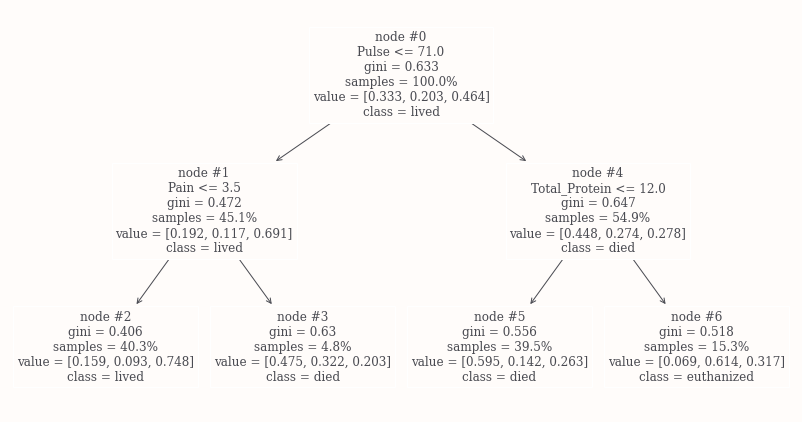

In [129]:
tree = DecisionTreeClassifier(max_depth=2, random_state=42).fit(X_full, y_full)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11.5, 6), tight_layout=True)
plot_tree(
    decision_tree=tree,
    feature_names=tree.feature_names_in_,  # type: ignore
    class_names=labels,  # type: ignore
    filled=False,
    impurity=True,
    proportion=True,
    node_ids=True,
    precision=3,
    fontsize=12,
    ax=ax,
)
plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Decision Process in Tree</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    So, we've got here a simple, default decision tree within a depth of $2$. I used such a depth to easily show you nodes. Such a tree has a micro-averaged $F_1$ score of around $0.65$ for CV scheme we set earlier ($5$ folds, $5$ repeats, stratification). Considering the depth it's rather decent result, isn't it? Tree used three different features to gain such a result, and these are <code>Pulse</code> (numerical), <code>Pain</code> (categorical), and <code>Total_Protein</code> (numerical). <b>So, these features probably will be at the top in the features importance in default</b> <code>RandomForestClassifier</code> <b>(we will see about that later).</b> Let's have a look how many and which features are considered when <code>max_depth</code> grows.
</p>

In [133]:
for depth in range(2, 6):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42).fit(X_full, y_full)
    used_features = np.unique(tree.tree_.feature[tree.tree_.feature != -2])  # -2 means a leaf
    used_features = X_full.columns[used_features].to_list()
    print(
        CLR + f"Features at depth {depth}: {RED}{len(used_features)}\n",
        *used_features,
        sep="\n",
    )
    print()


Features at depth 2: 3

Pain
Pulse
Total_Protein

Features at depth 3: 6

Surgery
Pain
Abdomo_Appearance
Rectal_Temp
Pulse
Total_Protein

Features at depth 4: 11

Surgery
Mucous_Membrane
Pain
Nasogastric_Reflux
Rectal_Exam_Feces
Abdomo_Appearance
Hospital_Number
Rectal_Temp
Pulse
Total_Protein
Abdomo_Protein

Features at depth 5: 18

Surgery
Temp_Of_Extremities
Mucous_Membrane
Capillary_Refill_Time
Pain
Abdominal_Distention
Nasogastric_Reflux
Rectal_Exam_Feces
Abdomen
Abdomo_Appearance
Hospital_Number
Rectal_Temp
Pulse
Respiratory_Rate
Nasogastric_Reflux_Ph
Packed_Cell_Volume
Total_Protein
Abdomo_Protein



<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #3A5A81;
">
    <b>Depth vs Used Features</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    At depth of $5$, the tree used $18\big/27$ features ($67$%). Are these $18$ variables are really important or the tree is learning from noise? We will check it in the next subsection by adding random features.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #3A5A81'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Random Variables &amp; Permutation Test</span></b><a class="anchor" id="random_variables_permutation_test"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    We will define a competition model now to utilise and evaluate it in further work. Here, we're going to start by introducing random variables to the dataset. Why? Well, when you introduce random variables to the dataset and train the model, you may check feature importances, for example, based on reduction in the mean squared error (MSE) criterion. <b>When a random variable contributes to the reduction of MSE more than the specific feature available in the dataset, it means that this feature is a noise indeed from the task perspective.</b>
</p>

In [134]:
np.random.seed(42)

X_full["RANDOM_1"] = np.random.normal(size=len(X_full))
X_full["RANDOM_2"] = np.random.normal(size=len(X_full))
X_full["RANDOM_3"] = np.random.normal(size=len(X_full))
X_full["RANDOM_4"] = np.random.normal(size=len(X_full))
X_full["RANDOM_5"] = np.random.normal(size=len(X_full))

forest = RandomForestClassifier(random_state=42).fit(X_full, y_full)


In [135]:
importances = (
    pd.DataFrame(
        {
            "Feature": forest.feature_names_in_,
            "Importance": forest.feature_importances_,
        }
    )
    .sort_values(by="Importance", ascending=False)
    .reset_index(drop=True)
)

highest_random_id = importances[importances.Feature.str.startswith("RANDOM")].index[0]
importances = importances.iloc[: highest_random_id + 1]

fig = px.bar(
    importances,
    x="Importance",
    y="Feature",
    color_discrete_sequence=["#6B6A6A"],
    opacity=0.5,
    height=480,
    width=840,
    title="Feature Importances in Default RF - Under Reduction in Gini Impurity<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Only six features are more important than random variable</span>",
)
fig.update_yaxes(showgrid=False, categoryorder="total ascending", title="")
fig.update_xaxes(showgrid=False, range=(-2e-3, 0.10))
fig.update_traces(width=0.6)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


In [136]:
np.random.seed(42)

seeds = np.random.randint(0, 19937, size=5)
permutation_f1 = defaultdict(list)

for seed in seeds:
    np.random.seed(seed)
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)

    for k, (train_ids, valid_ids) in enumerate(kfold.split(X_full, y_full)):
        X_train, y_train = X_full.iloc[train_ids], y_full[train_ids]  # type: ignore
        X_valid, y_valid = X_full.iloc[valid_ids], y_full[valid_ids]  # type: ignore

        forest.fit(X_train, y_train)
        f1 = f1_score(y_valid, forest.predict(X_valid), average="micro")

        for i, feature in enumerate(forest.feature_names_in_):
            X_shuffled = X_valid.copy()
            X_shuffled.iloc[:, i] = np.random.permutation(X_shuffled.iloc[:, i])
            f1_shuffled = f1_score(y_valid, forest.predict(X_shuffled), average="micro")
            # I assume a decrease in F1 if the attribute is essential.
            permutation_f1[feature].append(((f1 - f1_shuffled) / f1) * 100.0)


In [163]:
f1_decrease = (
    pd.DataFrame(permutation_f1)
    .mean()
    .round(3)
    .sort_values(ascending=False)
    .to_frame(name="Mean F1 Decrease (%)")
    .reset_index(names="Feature")
)

highest_random_id = f1_decrease[f1_decrease.Feature.str.startswith("RANDOM")].index[0]
f1_decrease = f1_decrease.iloc[: highest_random_id + 1]

fig = px.bar(
    f1_decrease,
    x="Mean F1 Decrease (%)",
    y="Feature",
    color_discrete_sequence=["#6B6A6A"],
    opacity=0.5,
    height=540,
    width=840,
    title="Mean F1 Decrease within Samples Permutation<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Using a 5-fold CV (5 Repeats) and 5 different seeds</span>",
)
fig.add_annotation(
    x=1.05,
    y=6.2,
    align="left",
    xanchor="left",
    text="<b>Samples permutation doesn't punish the model so<br>"
    "much. It seems that available features collaborate<br>"
    "and collectively contributes to the prediction.<br>"
    "16/27 had a higher impact than random variable.",
    showarrow=False,
)
fig.update_yaxes(showgrid=False, categoryorder="total ascending", title="")
fig.update_xaxes(showgrid=False, range=(-0.05, 3))
fig.update_traces(width=0.6)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


In [227]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, stratify=y_full, test_size=0.2, random_state=42
)

forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)
explainer = shap.TreeExplainer(
    forest,
    data=maskers.Independent(X_train, max_samples=len(X_train)),
    model_output="probability",
    feature_perturbation="interventional",
    feature_names=forest.feature_names_in_,
)

shap_values = np.array(explainer.shap_values(X_valid))
expected_values = np.array(explainer.expected_value)


 99%|===================| 735/741 [01:47<00:00]        

In [228]:
print(CLR + "Classes:", RED + f"{labels}")


Classes: ['died' 'euthanized' 'lived']


In [229]:
print(CLR + "Shap Values Array Shape:", f"{RED}{shap_values.shape}")


Shap Values Array Shape: (3, 247, 32)


In [231]:
forest.predict_proba(X_valid.iloc[[0]])


array([[0.54, 0.07, 0.39]])

In [233]:
shap_values[0, 0, :].sum() + expected_values[0]


0.5400406077959099

In [234]:
for label, expected_val in zip(labels, expected_values):
    print(
        CLR + "Class:",
        f"{RED}{label:12s}",
        CLR + "Expected Probability:",
        f"{RED}{expected_val:.3f}",
    )

print("\n", CLR + "Expected Probability Sum: ", f"{RED}{expected_values.sum():.3f}", sep="")


Class: died         Expected Probability: 0.330
Class: euthanized   Expected Probability: 0.204
Class: lived        Expected Probability: 0.466

Expected Probability Sum: 1.000


Outcome: Died


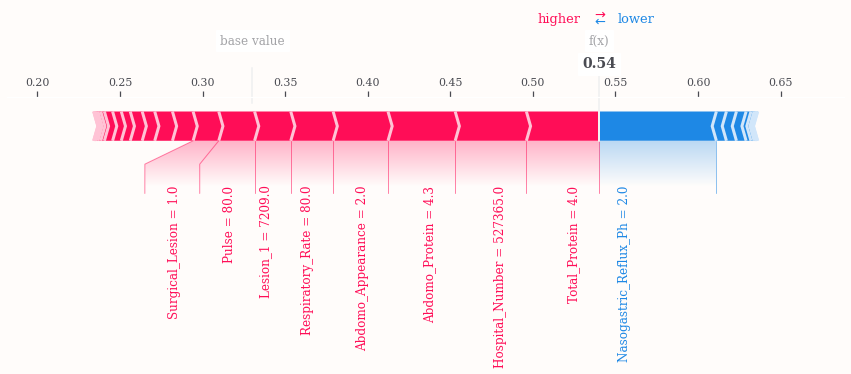

Outcome: Euthanized


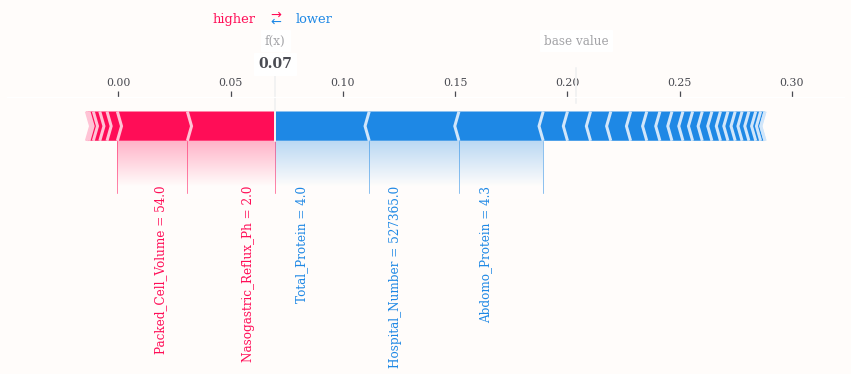

Outcome: Lived


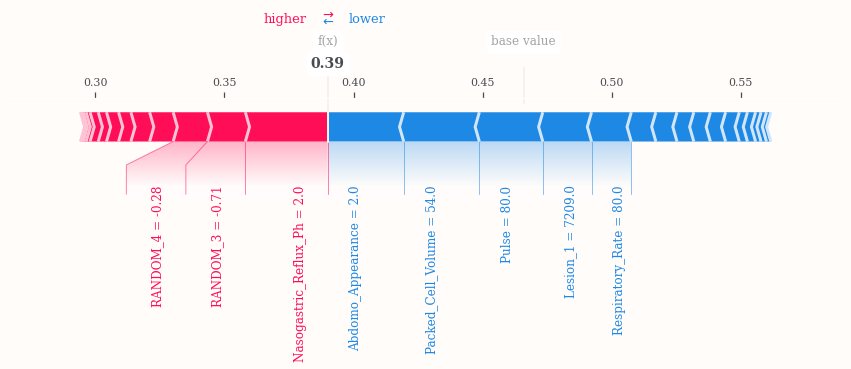

In [261]:
sample_no = 0

for k, label in enumerate(labels):
    print(CLR + "Outcome:", RED + label.title())
    shap.force_plot(
        expected_values[k],
        shap_values[k, sample_no, :],
        features=X_valid.iloc[[sample_no]].round(2),
        text_rotation=90,
        matplotlib=True,
        figsize=(15, 3.5),
    )
    plt.show()


In [268]:
print(CLR + "Outcome:", RED + "Died")
shap.initjs()
shap.force_plot(expected_values[0], shap_values[0], features=X_valid)


Outcome: Died


In [269]:
print(CLR + "Outcome:", RED + "Euthanized")
shap.force_plot(expected_values[1], shap_values[1], features=X_valid)


Outcome: Euthanized


In [270]:
print(CLR + "Outcome:", RED + "Lived")
shap.force_plot(expected_values[2], shap_values[2], features=X_valid)

Outcome: Lived


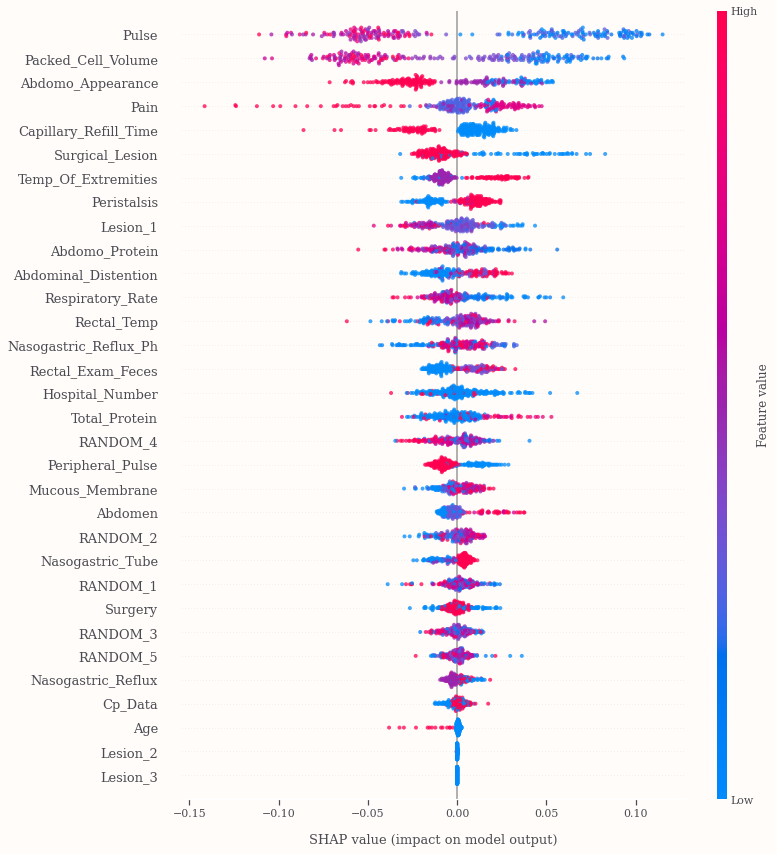

In [286]:
warnings.simplefilter("ignore")  # Some warning from matplotb - not important.
shap.summary_plot(
    shap_values[2],
    features=X_valid,
    max_display=len(X_valid.columns),
    axis_color=FONT_COLOR,
    class_names=labels,
    alpha=0.75,
    plot_size=(11.5, 12),
)


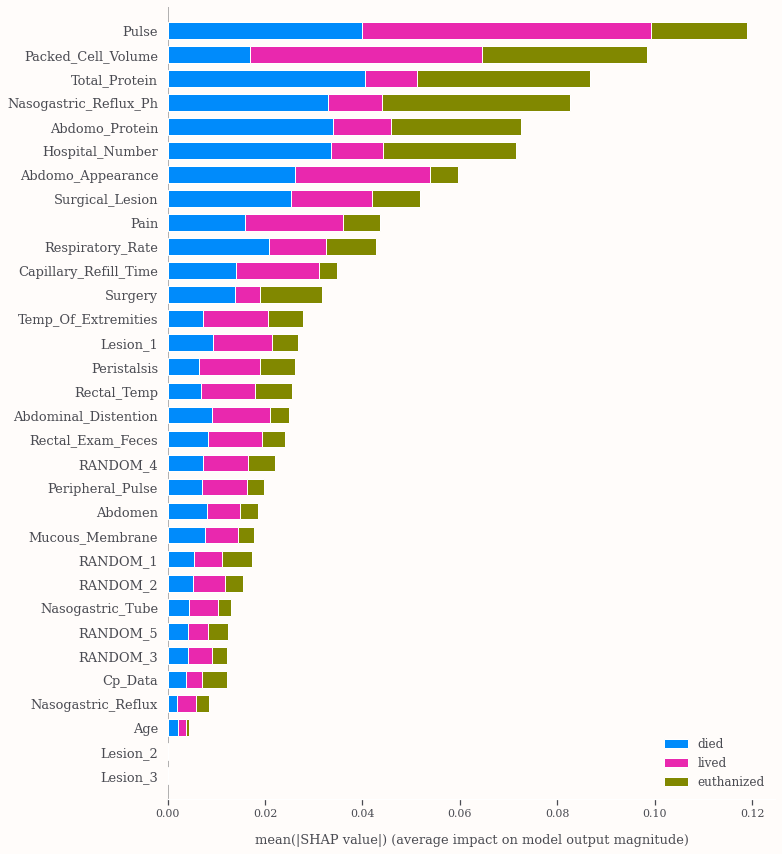

In [287]:
shap.summary_plot(
    list(shap_values),
    features=X_valid,
    max_display=len(X_valid.columns),
    axis_color=FONT_COLOR,
    class_names=labels,
    plot_size=(11, 12),
)


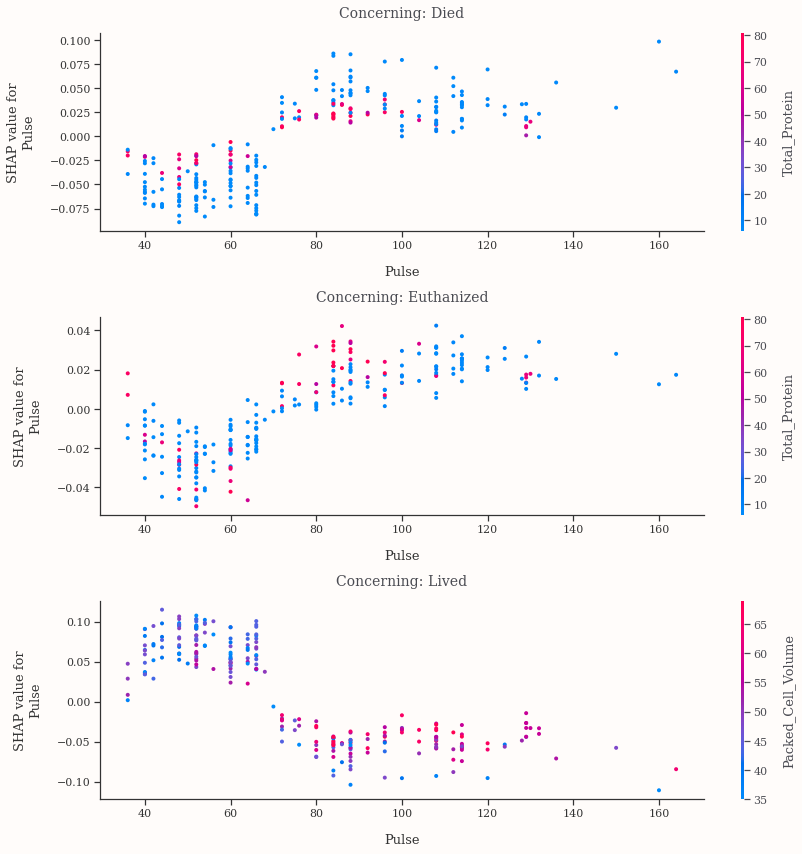

In [320]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), tight_layout=True)
shap.dependence_plot(
    "Pulse",
    shap_values=shap_values[0],
    features=X_valid,
    ax=axes[0],
    show=False,
)
shap.dependence_plot(
    "Pulse",
    shap_values=shap_values[1],
    features=X_valid,
    ax=axes[1],
    show=False,
)
shap.dependence_plot(
    "Pulse",
    shap_values=shap_values[2],
    features=X_valid,
    ax=axes[2],
    show=False,
)
axes[0].set_title("Concerning: " + labels[0].title())
axes[1].set_title("Concerning: " + labels[1].title())
axes[2].set_title("Concerning: " + labels[2].title())
plt.show()
